## Load all Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, Dropout
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import precision_score, recall_score

## Web scrap and Load Dataset

In [2]:
#scrap dataset
ticker = 'GME'
gmeData = yf.download(ticker, '2000-01-01', '2024-06-28')
gmeData.to_csv('GME.csv')

[*********************100%%**********************]  1 of 1 completed


## Feature Selection and Scalling the Data

In [3]:
# Select features
features = ['Open', 'High', 'Low', 'Close', 'Volume']

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(gmeData[features])

## Building the Autoencoder

In [4]:
# # Build the autoencoder
# input_dim = len(features)
# encoding_dim = 3

# input_layer = Input(shape=(input_dim,))
# encoder = Dense(encoding_dim, activation="relu")(input_layer)
# decoder = Dense(input_dim, activation="linear")(encoder)
# autoencoder = Model(inputs=input_layer, outputs=decoder)

# autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

def build_autoencoder(encoding_dim=5, input_dim=5, activation='relu', learning_rate=0.001, dropout_rate=0.0):
    input_layer = Input(shape=(input_dim,))
    encoder = Dense(encoding_dim, activation=activation)(input_layer)
    
    if dropout_rate > 0.0:
        encoder = Dropout(dropout_rate)(encoder)
    
    decoder = Dense(input_dim, activation='linear')(encoder)
    autoencoder = Model(inputs=input_layer, outputs=decoder)
    
    optimizer = Adam(learning_rate=learning_rate)
    autoencoder.compile(optimizer=optimizer, loss='mse')
    
    return autoencoder

# Example usage with additional parameters
autoencoder = build_autoencoder(encoding_dim=5, input_dim=5, activation='tanh', learning_rate=0.0005, dropout_rate=0.2)

## Evaluation Functions

In [5]:
def inject_synthetic_anomalies(data, anomaly_percentage=0.05):
    synthetic_data = data.copy()
    num_anomalies = int(len(data) * anomaly_percentage)
    anomaly_indices = np.random.choice(len(data), num_anomalies, replace=False)

    for idx in anomaly_indices:
        feature = np.random.choice(data.shape[1])
        synthetic_data[idx, feature] *= np.random.uniform(2, 3)

    true_labels = np.zeros(len(data))
    true_labels[anomaly_indices] = 1

    return synthetic_data, true_labels

def evaluate_model(model, data, true_labels):
    reconstructed = model.predict(data)
    mse = np.mean(np.power(data - reconstructed, 2), axis=1)
    threshold = np.percentile(mse, 95)
    predicted_labels = (mse > threshold).astype(int)

    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)

    return precision, recall

def precision_recall_at_k(true_labels, anomaly_scores, k):
    threshold = np.percentile(anomaly_scores, 100 - k)
    predictions = (anomaly_scores >= threshold).astype(int)

    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)

    return precision, recall

## Creating Synthetic Anomalies

In [6]:
synthetic_data, true_labels = inject_synthetic_anomalies(scaled_data)

## Cross Validation

In [7]:
tscv = TimeSeriesSplit(n_splits=5)
precisions, recalls = [], []

for train_index, test_index in tscv.split(synthetic_data):
    train_data, test_data = synthetic_data[train_index], synthetic_data[test_index]
    test_labels = true_labels[test_index]

    # Train autoencoder
    autoencoder.fit(train_data, train_data, epochs=100, batch_size=32, verbose=0)

    # Evaluate
    precision, recall = evaluate_model(autoencoder, test_data, test_labels)
    precisions.append(precision)
    recalls.append(recall)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [8]:
print(f"Average Precision: {np.mean(precisions):.4f}")
print(f"Average Recall: {np.mean(recalls):.4f}")

Average Precision: 0.6681
Average Recall: 0.6935


## Isolation Forest - Compare with Encoder

In [9]:
isolationForest = IsolationForest(
    contamination="auto",
    random_state=42,
    n_estimators=1000,
    max_samples='auto',
    max_features=1.0,
    bootstrap=False,
    n_jobs=-1,
    verbose=0,
    warm_start=False
)

In [10]:
isolationForest.fit(synthetic_data)
iso_predictions = isolationForest.predict(synthetic_data)
iso_predictions = (iso_predictions == -1).astype(int)

iso_precision = precision_score(true_labels, iso_predictions)
iso_recall = recall_score(true_labels, iso_predictions)

In [11]:
print(f"Isolation Forest Precision: {iso_precision:.4f}")
print(f"Isolation Forest Recall: {iso_recall:.4f}")

Isolation Forest Precision: 0.0807
Isolation Forest Recall: 0.2420


## Train the Final Autoencoder

In [12]:
history = autoencoder.fit(scaled_data, scaled_data,
                          epochs=50, batch_size=64,
                          shuffle=True, validation_split=0.3,
                          verbose=1)

Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.7021e-05 - val_loss: 4.9901e-04
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.8760e-05 - val_loss: 5.1951e-04
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.7196e-05 - val_loss: 4.7277e-04
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.6725e-05 - val_loss: 5.2755e-04
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.6523e-05 - val_loss: 4.9583e-04
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.6456e-05 - val_loss: 5.1759e-04
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.1689e-05 - val_loss: 5.0015e-04
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.1409e-05 - val_loss: 5.5111e-04
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.5043e-05 - val_loss: 4.9723e-04
Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.1231e-05 - val_loss: 4.9923e-04
Epoch 11/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.5703e-05 - val_los

## Reconstruct the Data

In [13]:
reconstructed_data = autoencoder.predict(scaled_data)

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step


## Calculating the Mean Squared Error

In [14]:
mse = np.mean(np.power(scaled_data - reconstructed_data, 2), axis=1)

## Detect Outliers

In [15]:
# Define threshold for outliers (e.g., 95th percentile of MSE)
threshold = np.percentile(mse, 95)

# Identify outliers
gmeData['Outlier'] = (mse > threshold).astype(int)

## Precision and Recall

In [16]:
for k in [1, 5, 10]:
    p, r = precision_recall_at_k(true_labels, mse, k)
    print(f"Precision at {k}%: {p:.4f}, Recall at {k}%: {r:.4f}")

Precision at 1%: 0.0877, Recall at 1%: 0.0178
Precision at 5%: 0.0496, Recall at 5%: 0.0498
Precision at 10%: 0.0514, Recall at 10%: 0.1032


## Plot the Results and Features

In [17]:
def plot_results(df, feature):
    plt.figure(figsize=(15, 7))

    plt.plot(df.index, df[feature], label=feature, color='blue', alpha=0.7)

    outliers = df[df['Outlier'] == 1]
    plt.scatter(outliers.index, outliers[feature],
                color='red', label='Outliers', s=50)

    plt.title(f'GME Stock {feature} with Outliers (Autoencoder)')
    plt.xlabel('Date')
    plt.ylabel(feature)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

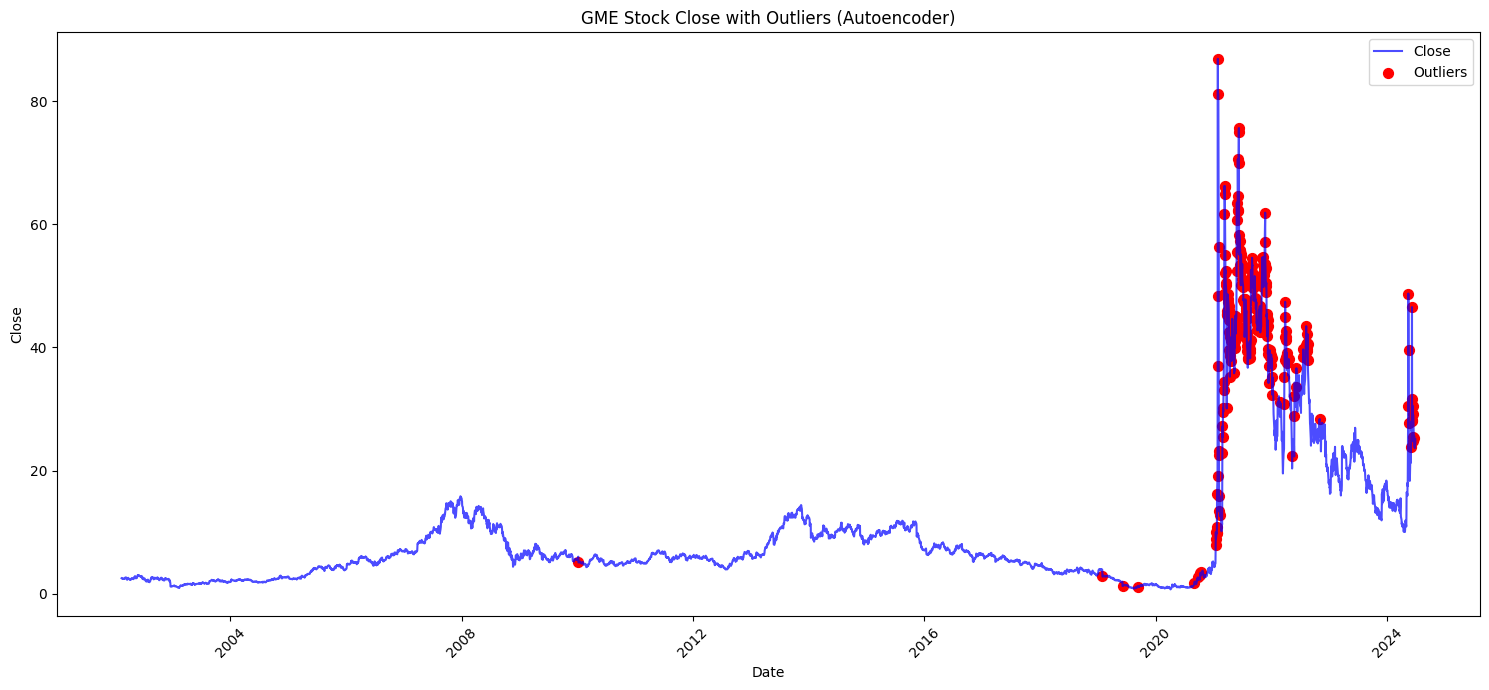

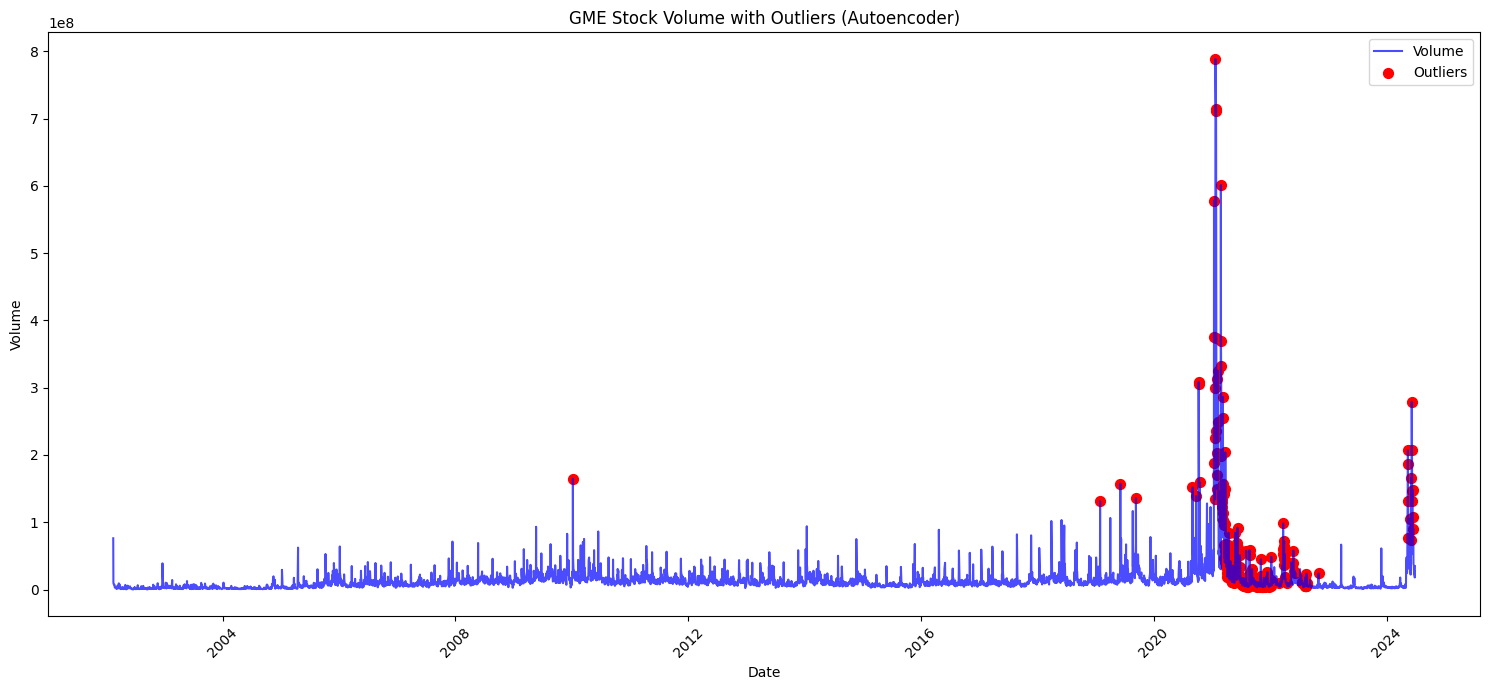

In [18]:
# Plot for Close price and Volume
plot_results(gmeData, 'Close')
plot_results(gmeData, 'Volume')

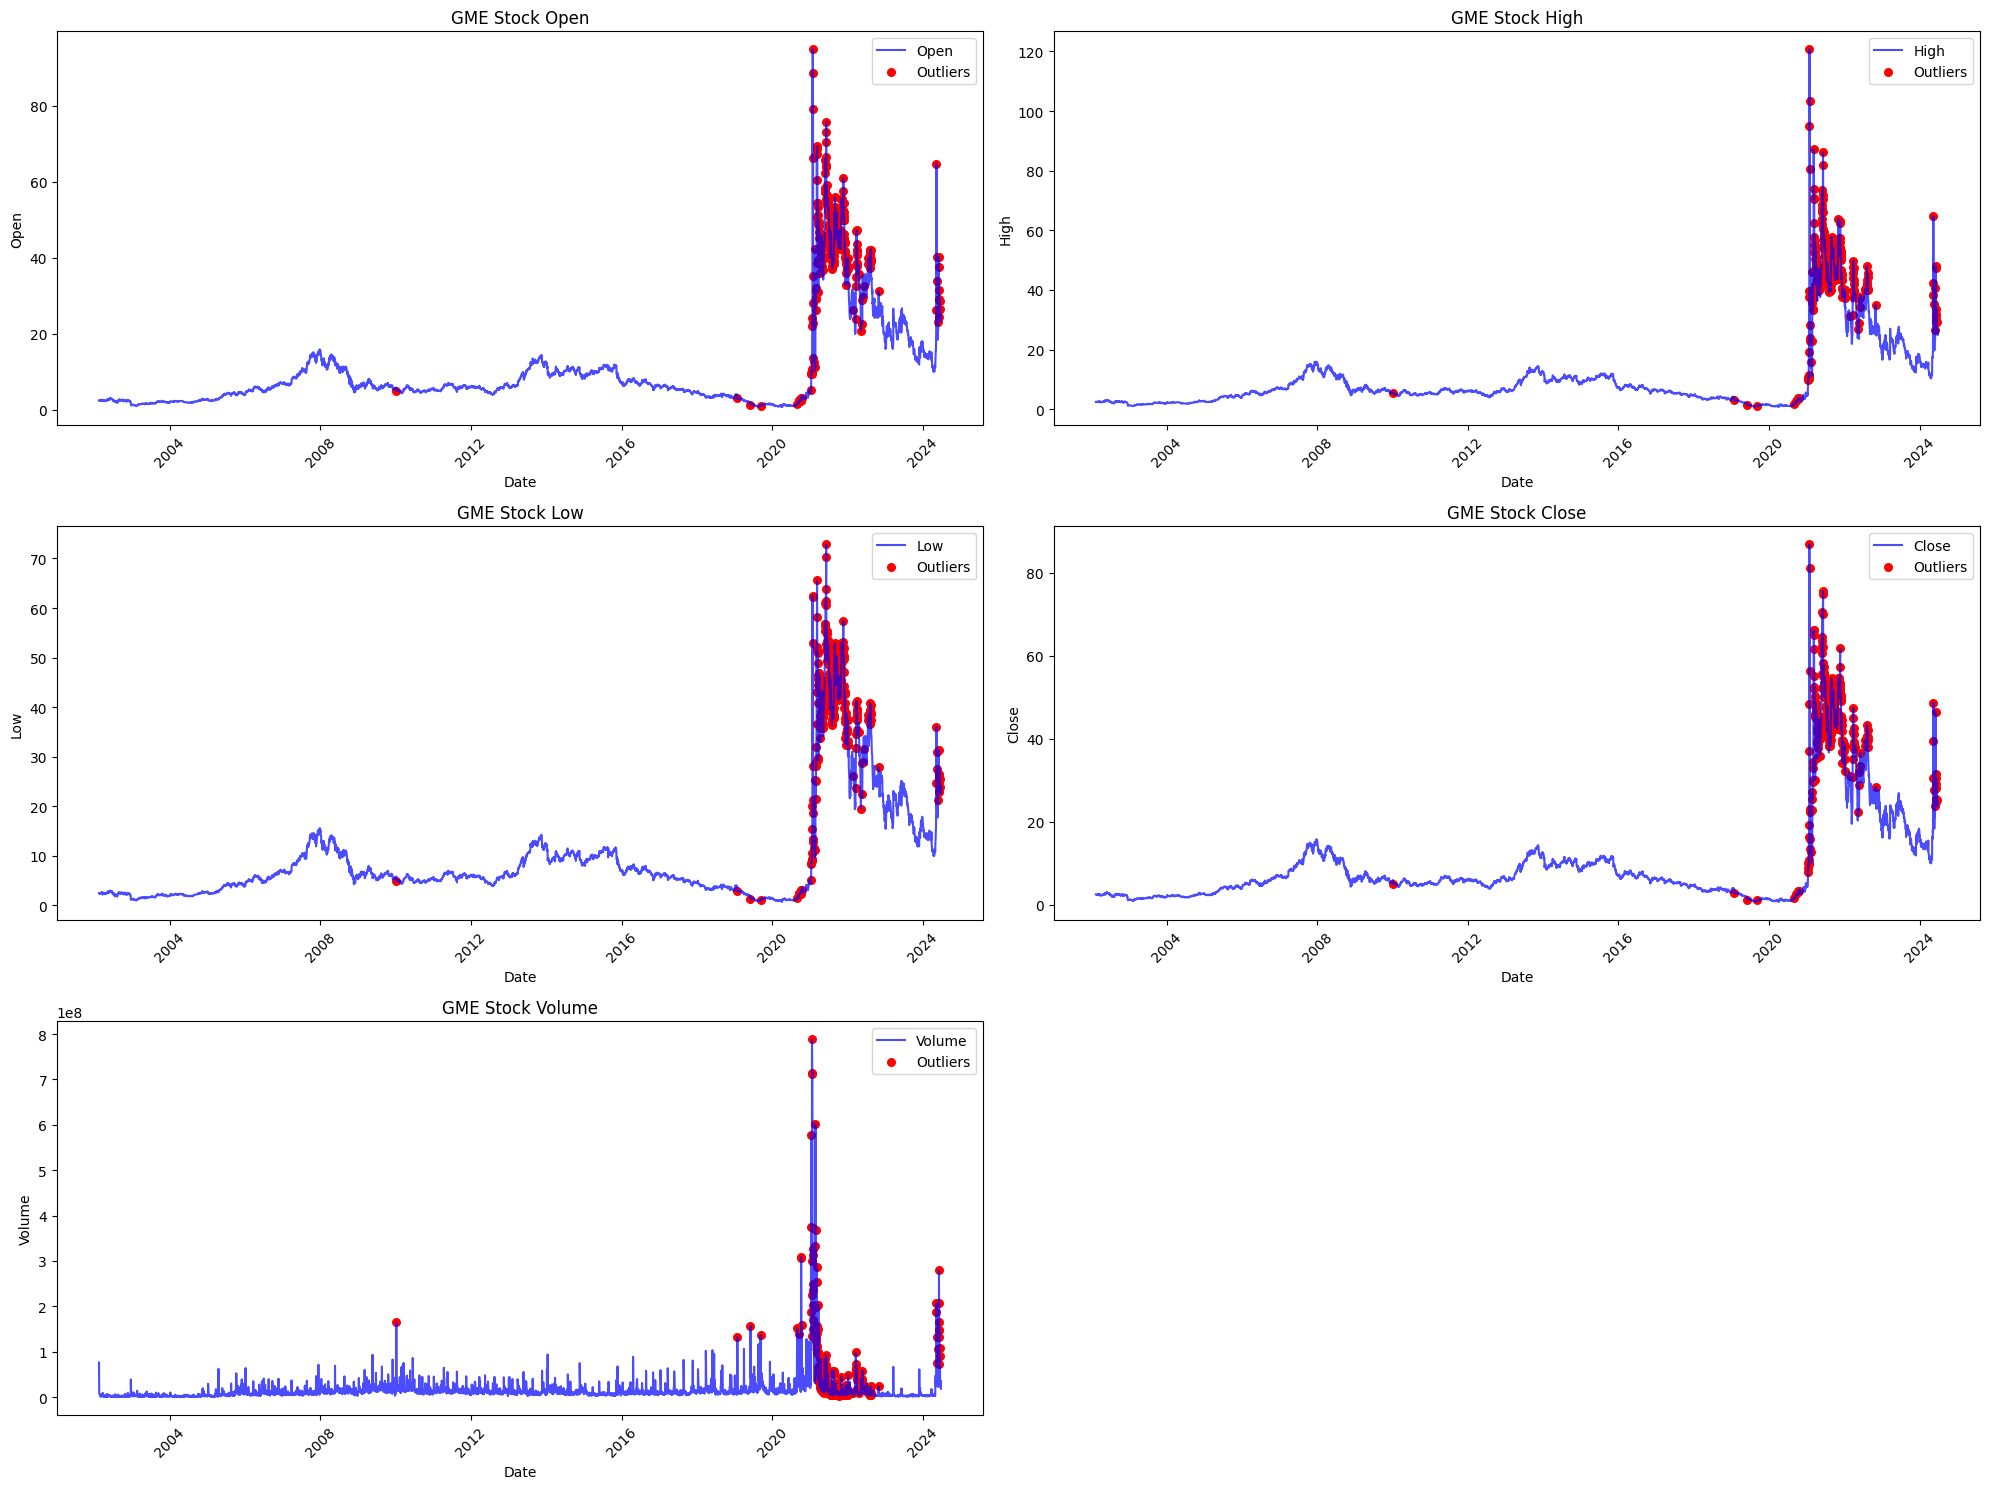

In [19]:
# Plot all features
plt.figure(figsize=(20, 15))
features = ['Open', 'High', 'Low', 'Close', 'Volume']
for i, feature in enumerate(features, 1):
    plt.subplot(3, 2, i)

    plt.plot(gmeData.index, gmeData[feature], label=feature, color='blue', alpha=0.7)
    outliers = gmeData[gmeData['Outlier'] == 1]
    plt.scatter(outliers.index, outliers[feature],
                color='red', label='Outliers', s=30)

    plt.title(f'GME Stock {feature}')
    plt.xlabel('Date')
    plt.ylabel(feature)
    plt.legend()
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Show Detected Outliers

In [20]:
print(gmeData.columns)
print(gmeData.head().to_dict())

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Outlier'], dtype='object')
{'Open': {Timestamp('2002-02-13 00:00:00'): 2.40625, Timestamp('2002-02-14 00:00:00'): 2.543750047683716, Timestamp('2002-02-15 00:00:00'): 2.5, Timestamp('2002-02-19 00:00:00'): 2.4749999046325684, Timestamp('2002-02-20 00:00:00'): 2.4000000953674316}, 'High': {Timestamp('2002-02-13 00:00:00'): 2.515000104904175, Timestamp('2002-02-14 00:00:00'): 2.5487499237060547, Timestamp('2002-02-15 00:00:00'): 2.5062499046325684, Timestamp('2002-02-19 00:00:00'): 2.4749999046325684, Timestamp('2002-02-20 00:00:00'): 2.46875}, 'Low': {Timestamp('2002-02-13 00:00:00'): 2.3812499046325684, Timestamp('2002-02-14 00:00:00'): 2.481250047683716, Timestamp('2002-02-15 00:00:00'): 2.4625000953674316, Timestamp('2002-02-19 00:00:00'): 2.34375, Timestamp('2002-02-20 00:00:00'): 2.3812499046325684}, 'Close': {Timestamp('2002-02-13 00:00:00'): 2.512500047683716, Timestamp('2002-02-14 00:00:00'): 2.5, Timestamp('2002-02-

In [21]:
# Print summary of detected outliers
print("Outliers detected:")
outliers = gmeData[gmeData['Outlier'] == 1]
print(outliers.reset_index().to_string(index=False))

# Calculate percentage of outliers
outlier_percentage = gmeData['Outlier'].mean() * 100
print(f"\nPercentage of outliers: {outlier_percentage:.2f}%")

Outliers detected:
      Date      Open       High       Low     Close  Adj Close    Volume  Outlier
2010-01-07  5.002500   5.292500  4.855000  5.115000   3.443930 164761200        1
2019-01-29  3.097500   3.125000  2.777500  2.820000   2.727461 131481200        1
2019-06-05  1.372500   1.397500  1.177500  1.260000   1.260000 157416800        1
2019-09-11  1.047500   1.237500  0.992500  1.147500   1.147500 136020000        1
2020-08-31  1.442500   1.787500  1.422500  1.670000   1.670000 151904000        1
2020-09-22  2.612500   2.792500  2.475000  2.640000   2.640000 139010000        1
2020-10-08  2.385000   3.410000  2.297500  3.372500   3.372500 305814400        1
2020-10-09  3.207500   3.700000  2.975000  3.005000   3.005000 308611200        1
2020-10-15  2.997500   3.775000  2.997500  3.457500   3.457500 159579200        1
2021-01-13  5.105000   9.662500  5.007500  7.850000   7.850000 578006800        1
2021-01-14  9.522500  10.765000  8.262500  9.977500   9.977500 374869600       

## Plot Reconstruction Error

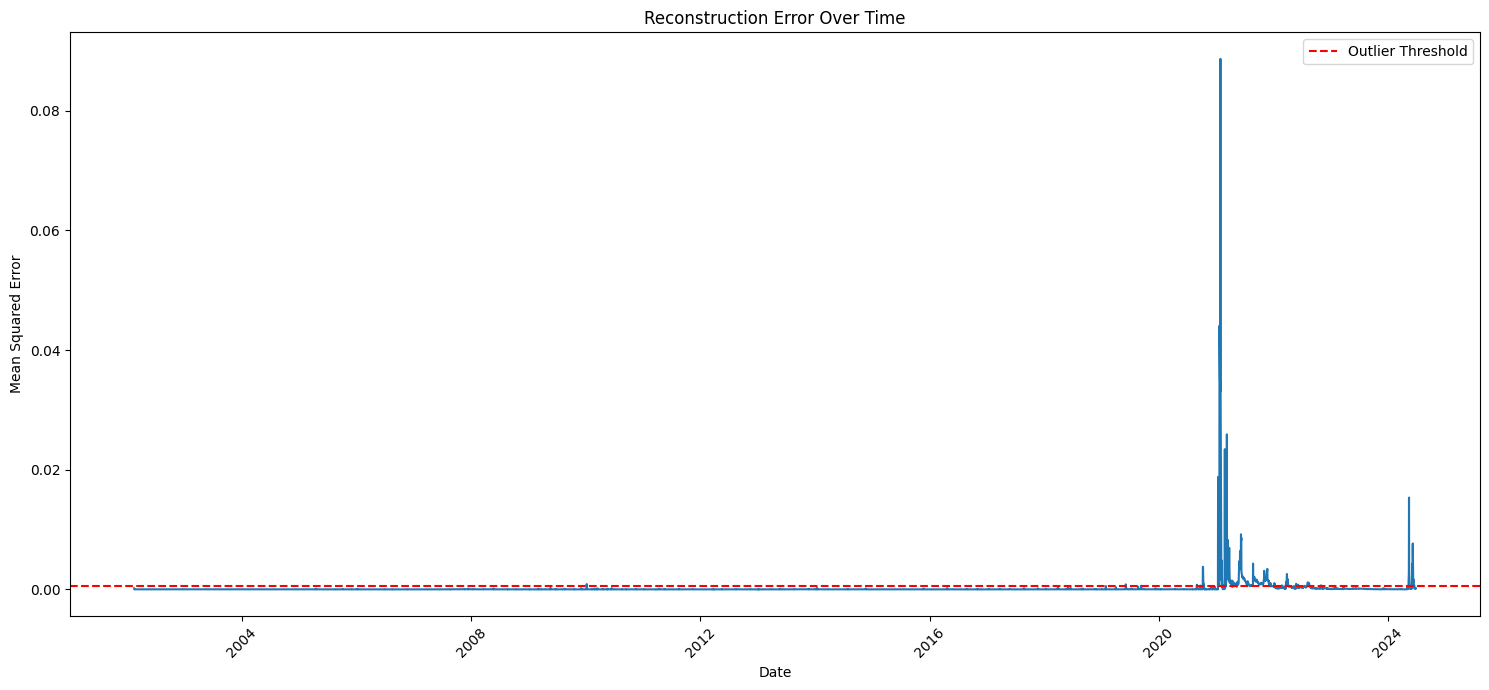

In [22]:
plt.figure(figsize=(15, 7))
plt.plot(gmeData.index, mse)
plt.title('Reconstruction Error Over Time')
plt.xlabel('Date')
plt.ylabel('Mean Squared Error')
plt.axhline(y=threshold, color='r', linestyle='--', label='Outlier Threshold')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Plot Training History

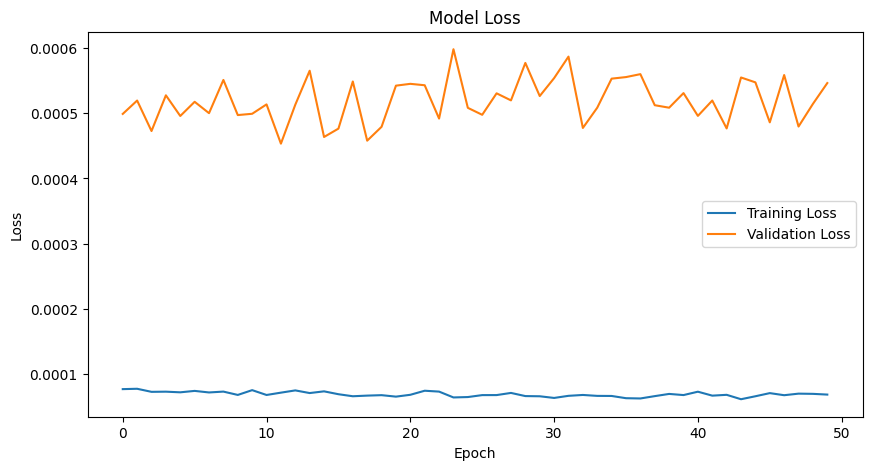

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()